In [1]:
import sys

sys.argv = ['']
sys.path.append("../..")
from src.grid_world import GridWorld
from examples.agent import Agent
import torch.nn as nn
from torch.optim import Optimizer
from torch import optim
import random
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F

In [2]:
class QNet(nn.Module):
    """
    Q(s, a) 网络
    输入: 状态one-hot向量（num_states维）
    输出: 所有动作的Q值（num_actions维）
    """

    def __init__(self, num_states, num_actions):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(num_states, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
class Sarsa(Agent):
    def __init__(self, env, num_episodes=5000, episode_length=1000,
                 gamma=0.9, alpha=1e-2, epsilon=0.1):
        super().__init__(
            env=env,
            epsilon=epsilon,
            gamma=gamma,
            num_episodes=num_episodes,
            episode_length=episode_length
        )
        self.alpha = alpha
        # 初始化Q网络（输入为状态one-hot维度）
        self.QNet = QNet(self.num_states, self.num_actions)
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.QNet.parameters(), lr=alpha)  # 改用Adam优化器

    def run(self):
        for episode in tqdm(range(self.num_episodes), desc="Training"):
            self.env.reset()
            s0 = self.env.start_state
            s0_idx = self.state2idx(s0)
            a0_idx = self.choose_action(s0_idx)

            total_reward = 0
            step = 0

            while step < self.episode_length:
                # 执行动作
                a0 = self.idx2action(a0_idx)
                s_next, reward, done, _ = self.env.step(a0)
                s_next_idx = self.state2idx(s_next)
                a_next_idx = self.choose_action(s_next_idx)

                total_reward += reward

                # 更新Q值
                self.update(s0_idx, a0_idx, reward, s_next_idx, a_next_idx, done)

                # 更新策略
                self.update_policy(s0_idx)

                # 终止条件
                if done:
                    break

                # 迭代状态和动作
                s0_idx = s_next_idx
                a0_idx = a_next_idx
                step += 1

            # 每100轮打印进度
            if (episode + 1) % 100 == 0:
                tqdm.write(f"Episode {episode + 1}, Total Reward: {total_reward}")

    def update(self, s, a, r, s_next, a_next, done):
        """
        修正的Sarsa更新规则
        """
        # 关键修复：确保张量是整数类型（int64），并添加边界检查
        # 检查状态索引是否有效
        if not (0 <= s < self.num_states):
            raise ValueError(f"Invalid state index: {s}, num_states={self.num_states}")
        if not (0 <= s_next < self.num_states):
            raise ValueError(f"Invalid next state index: {s_next}, num_states={self.num_states}")

        # 显式指定张量类型为torch.long（int64），这是one_hot要求的索引类型
        s_tensor = torch.tensor(s, dtype=torch.long)
        s_next_tensor = torch.tensor(s_next, dtype=torch.long)

        # 状态one-hot编码（正确的输入方式）
        s_onehot = F.one_hot(s_tensor, num_classes=self.num_states).float().unsqueeze(0)
        s_next_onehot = F.one_hot(s_next_tensor, num_classes=self.num_states).float().unsqueeze(0)

        # 当前Q值（仅选当前动作的Q值）
        q_values = self.QNet(s_onehot)
        q_value = q_values[0, a].unsqueeze(0)

        # 计算TD目标
        with torch.no_grad():
            if done:
                td_target = torch.tensor([r], dtype=torch.float)
            else:
                q_next_values = self.QNet(s_next_onehot)
                q_next_value = q_next_values[0, a_next]
                td_target = torch.tensor([r], dtype=torch.float) + self.gamma * q_next_value

        # 损失计算与反向传播
        loss = self.loss_fn(q_value, td_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # 更新Q表（同步网络输出）
        self.Q[s, a] = q_value.item()

        return loss.item()

    def update_policy(self, st_idx):
        """
        基于当前Q值更新ε-贪婪策略
        """
        # 检查状态索引有效性
        if not (0 <= st_idx < self.num_states):
            raise ValueError(f"Invalid state index: {st_idx}, num_states={self.num_states}")

        # 显式指定张量类型为torch.long
        st_tensor = torch.tensor(st_idx, dtype=torch.long)
        # 用网络计算当前状态的所有动作Q值
        s_onehot = F.one_hot(st_tensor, num_classes=self.num_states).float().unsqueeze(0)
        with torch.no_grad():
            q_values = self.QNet(s_onehot).squeeze(0).numpy()

        # 贪婪动作
        greedy_action = np.argmax(q_values)

        # 更新策略
        for a in range(self.num_actions):
            if a == greedy_action:
                self.policy[st_idx, a] = 1 - self.epsilon + (self.epsilon / self.num_actions)
            else:
                self.policy[st_idx, a] = self.epsilon / self.num_actions


In [4]:
env = GridWorld()
env.reward_step = 0
env.reward_target = 1000

Training:  10%|█         | 101/1000 [00:19<01:29, 10.04it/s]

Episode 100, Total Reward: 785


Training:  21%|██        | 208/1000 [00:23<00:21, 36.79it/s]

Episode 200, Total Reward: 1000


Training:  30%|███       | 304/1000 [00:26<00:20, 34.78it/s]

Episode 300, Total Reward: 980


Training:  40%|████      | 404/1000 [00:29<00:17, 34.37it/s]

Episode 400, Total Reward: 995


Training:  50%|█████     | 504/1000 [00:31<00:12, 40.16it/s]

Episode 500, Total Reward: 980


Training:  60%|██████    | 602/1000 [00:34<00:10, 36.19it/s]

Episode 600, Total Reward: 995


Training:  70%|███████   | 705/1000 [00:37<00:07, 36.93it/s]

Episode 700, Total Reward: 985


Training:  81%|████████  | 806/1000 [00:40<00:04, 39.23it/s]

Episode 800, Total Reward: 990


Training:  90%|█████████ | 905/1000 [00:42<00:02, 37.71it/s]

Episode 900, Total Reward: 1000


Training: 100%|██████████| 1000/1000 [00:45<00:00, 21.87it/s]


Episode 1000, Total Reward: 990


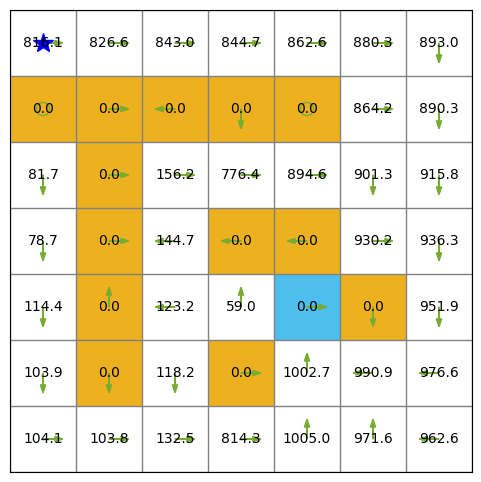

Final Policy:
[[0.06 0.76 0.06 0.06 0.06]
 [0.06 0.76 0.06 0.06 0.06]
 [0.06 0.76 0.06 0.06 0.06]
 [0.06 0.76 0.06 0.06 0.06]
 [0.06 0.76 0.06 0.06 0.06]
 [0.06 0.76 0.06 0.06 0.06]
 [0.76 0.06 0.06 0.06 0.06]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.06 0.76 0.06 0.06 0.06]
 [0.76 0.06 0.06 0.06 0.06]
 [0.76 0.06 0.06 0.06 0.06]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.06 0.76 0.06 0.06 0.06]
 [0.06 0.76 0.06 0.06 0.06]
 [0.06 0.76 0.06 0.06 0.06]
 [0.76 0.06 0.06 0.06 0.06]
 [0.76 0.06 0.06 0.06 0.06]
 [0.76 0.06 0.06 0.06 0.06]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.06 0.06 0.06 0.76 0.06]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.06 0.76 0.06 0.06 0.06]
 [0.76 0.06 0.06 0.06 0.06]
 [0.76 0.06 0.06 0.06 0.06]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.06 0.06 0.06 0.76 0.06]
 [0.06 0.06 0.76 0.06 0.06]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2 ]
 [0.76 0.06 0.06 0.06 0.06]
 [0.76

In [6]:
agent = Sarsa(env, epsilon=0.3, gamma=0.99, num_episodes=1000, episode_length=1000, alpha=1e-3)
agent.run()
agent.render_static()
print("Final Policy:")